# Text IR techniques applied to Music IR

In this notebook we'll build several IR querying systems for music search using a wide range of techniques that are commonly used in text retrieval systems. These include some NLP techniques such as bag-of-words, n-grams and TF-IDF.

We're going to use _music21_, a library developed in MIT for sheet music manipulation. The library supports several formats, such as ``.mid``, ``.mxl`` and others that are not going to be used in this notebook.

Also, we'll use _ffmpeg_, a library which we'll use to capture audio from the user.

In [ ]:
!pip install music21

In [ ]:
%cd drive/My\ Drive/MIR

[Errno 2] No such file or directory: 'drive/My Drive/MIR'
/content/drive/My Drive/MIR


## 1. Dataset

First, we'll build a small dataset to include in our MIR system. The following songs are in the dataset:

1. Canon in D - Pachelbel
2. Memories - Maroon 5
3. He could be the one - Hannah Montana
4. Bet on it - High School Musical
5. C major scale

All the chosen songs have only one melodic line, and the choice to include Canon and Memories was based on their major similarity, as Memories was based on Canon in D. Bet on it and He could be the one have both a very frequent occurency of unisson melodic intervals, which make them structurally similar to each other and very different to the other songs. The C major scale was chosen because of its small size compared to the other songs, so we can evaluate if the size of the document has impacts on the results.

Below, we import the documents and the queries (two measures from each song).

In [ ]:
from music21 import *
canon_score = converter.parse("canon.mid").parts[0]
memories_score = converter.parse("memories.mid").parts[0]
hannah_score = converter.parse("hannah.mid").parts[0]
hsm_score = converter.parse("hsm.mid").parts[0]
cmaj_score = converter.parse("cmaj.mxl").parts[0].flat

query_canon_score = converter.parse('query/query_canon.mid').parts[0]
query_memories_score = converter.parse('query/query_memories.mid').parts[0]

#2. Bag-of-words and n-grams

Below, you can see two note division methods. First, we have a division by measures, which only takes the time signature into consideration. In this method, the length of the "words" can differ widely. Next, we have a n-gram function, that divides the notes in the score based only on the n. 

In both methods, after the notes are divided into groups, we calculate the melodic intervals between the notes inside each group, and we use the output data to create a bag-of-words of the intervals, using the `Counter` data structure from de `collections` library.

This pre-processing can be used for both the "document" scores and the "query" scores.

In [ ]:
from collections import Counter
def measure_sep(score, time_sig = 4):
  measures = []
  for i in score:
    try:
      if i.isNote:
        if i.offset%time_sig == 0:
          measures.append([])
        measures[-1].append(i)
    except:
      continue
  intervals = []
  for m in measures:
    m_int = ''
    for n in range(len(m)-1):
      i = interval.Interval(m[n+1], m[n])
      m_int += str(i.semitones) + ' '
    intervals.append(m_int)
  return Counter(intervals)

In [ ]:
def ngram(score, n):
  score2 = []
  for i in score:
    try:
      i.step
      score2.append(i)
    except:
      continue

  note_groups = []
  for i in range(len(score2)):
    for j in range(n):
      if j == 0:
        note_groups.append([])
      try:
        note_groups[-1].append(score2[i+j])
      except:
        continue
  
  intervals = []
  for m in note_groups:
    m_int = ''
    for n in range(len(m)-1):
      i = interval.Interval(m[n+1], m[n])
      m_int += str(i.semitones) + ' '
    intervals.append(m_int)
  
  return Counter(intervals)

The above functions are used in each document and query, which is made easier with the function below. We also group the documents and queries, as to facilitate our subsequential tasks.

In [ ]:
def score_division(score, name):
  return [name, measure_sep(score), 
          ngram(score, 2), 
          ngram(score, 3), 
          ngram(score, 4)]

In [ ]:
canon = score_division(canon_score, "Canon in D - Pachelbel")
memories = score_division(memories_score, "Memories - Maroon 5")
hannah = score_division(hannah_score, "He Could be the One - Hannah Montana")
hsm = score_division(hsm_score, "Bet on it - High School Musical 2")
cmaj = score_division(cmaj_score, "C major scale")

docs = [canon, memories, hannah, hsm, cmaj]

query_canon = score_division(query_canon_score, "Unknown")
query_memories = score_division(query_memories_score, "Unknown")

queries = [query_canon, query_memories]

The order of the bag-of-words Counters is:

`[name, measure division, 2gram, 3gram, 4gram]`

Where "name" is the name of the score (and where we would keep the metadata). Note that the metadata of the queries are marked as "unknown".

Below, we can see the barplot of two bag-of-words Counters. The first is the _bow_ of Canon in D using the measure separation method, and the second is the _bow_ of the Canon in D query, usin the same method. Note that the query is way more uniform than the Canon in D whole song, as the query presents no repetitions. The song, however, has 8 distinct "common words".

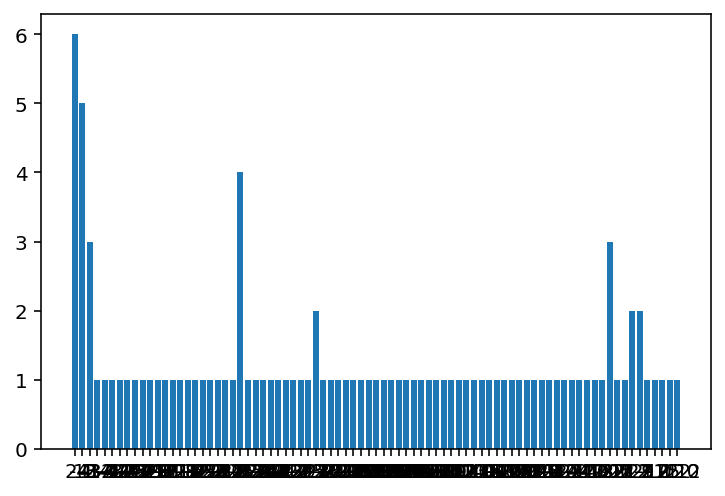

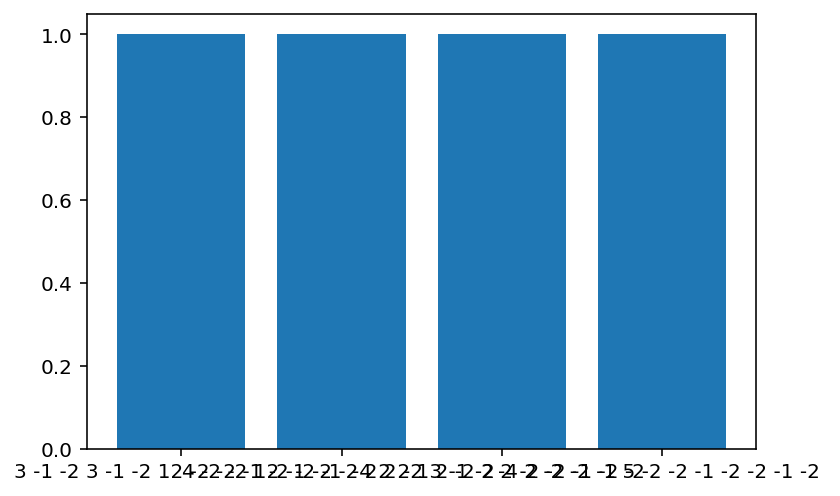

In [ ]:
import matplotlib.pyplot as plt

plt.bar(canon[1].keys(), canon[1].values())
plt.show()

plt.bar(query_canon[1].keys(), query_canon[1].values())
plt.show()

#3. Vector Space Models

Now, we have everything we need to build our Vector Space Models, that will make it possible for us to actually search the queries in our document database. 

The function below will gather all of the "vocabulary" provenient from the documents (i.e. unique words). Since the "words" differ depending on the division method used, we are going to build a vocabulary for each method.

In [ ]:
import numpy as np

def vocabulary(documents):
  vocab = []
  for d in documents:
    for word in d.keys():
      if word not in vocab:
        vocab.append(word)
  return np.array(vocab)

In [ ]:
vocabularies = [vocabulary([msep[1] for msep in docs]), 
                vocabulary([gram2[2] for gram2 in docs]), 
                vocabulary([gram3[3] for gram3 in docs]), 
                vocabulary([gram4[4] for gram4 in docs])]

##3.1. Bit Vector Space Model

The first Vector Space Model we'll use is the Bit Vector Model. For each unique match between the document words and the vocabulary words, we mark the correspondent cell with "1", and otherwise, we mark it as "0". This is the most simple Vector Space Model, since we consider only the unique match between words, and not the Term Frequency. Below, we show the two bit vsm functions (for the documents and for the queries).

In [ ]:
def bit_vsm_matrix(documents, vocab):
  resp = np.zeros((len(documents), len(vocab)))
  for d in range(len(documents)):
    keys = documents[d].keys()
    for i in range(len(vocab)):
      if vocab[i] in keys:
        resp[d, i] = 1
  return resp

def bit_vsm_query(query, vocab):
  resp = np.zeros(len(vocab))
  for i in range(len(vocab)):
    if vocab[i] in query:
      resp[i] = 1
  #resp = np.tile(resp, (len(docs), 1))
  return resp

Next, we apply the functions to all the documents, grouped by division method, and the different queries, also grouped by division method.

In [ ]:
bit_vsm_matrixes = [bit_vsm_matrix([t[i+1] for t in docs], vocabularies[i]) for i in range(len(vocabularies))]

bit_vsm_query_canon = [bit_vsm_query(queries[0][i+1], vocabularies[i]) for i in range(len(vocabularies))]

bit_vsm_query_memories = [bit_vsm_query(queries[1][i+1], vocabularies[1]) for i in range(len(vocabularies))]

Now we are able to write the search function, that will perform the dot product between the query and each document in the matrix of documents. The search function will return a vector containing all of the scores for each match (i.e. the "ranking").

In [ ]:
def search_ranking(query, matrix, documents):
  score = np.dot(query, np.transpose(matrix))
  ranking = Counter()
  for d in range(len(documents)):
    ranking[documents[d][0]] = score[d]
  return ranking

Finally, we can search a query in our bit vector matrix models. Below, an example searching the Canon in D query using the each division method:

In [ ]:
print(search_ranking(bit_vsm_query_canon[0], bit_vsm_matrixes[0], docs).most_common())
print(search_ranking(bit_vsm_query_canon[1], bit_vsm_matrixes[1], docs).most_common())
print(search_ranking(bit_vsm_query_canon[2], bit_vsm_matrixes[2], docs).most_common())
print(search_ranking(bit_vsm_query_canon[3], bit_vsm_matrixes[3], docs).most_common())

[('Canon in D - Pachelbel', 4.0), ('Memories - Maroon 5', 0.0), ('He Could be the One - Hannah Montana', 0.0), ('Bet on it - High School Musical 2', 0.0), ('C major scale', 0.0)]
[('Canon in D - Pachelbel', 10.0), ('Memories - Maroon 5', 10.0), ('He Could be the One - Hannah Montana', 9.0), ('Bet on it - High School Musical 2', 9.0), ('C major scale', 5.0)]
[('Canon in D - Pachelbel', 23.0), ('Memories - Maroon 5', 18.0), ('Bet on it - High School Musical 2', 14.0), ('He Could be the One - Hannah Montana', 13.0), ('C major scale', 7.0)]
[('Canon in D - Pachelbel', 37.0), ('Memories - Maroon 5', 25.0), ('He Could be the One - Hannah Montana', 14.0), ('Bet on it - High School Musical 2', 8.0), ('C major scale', 6.0)]


Now, we'll take into account every division method by taking the average score of each word after using each method. The average scores are going to be the final ranking.

In [ ]:
def search_avg(query, matrixes, documents):
  searches = [search_ranking(query[i], matrixes[i], documents) for i in range(len(matrixes))]

  sum_search = np.zeros(len(documents))

  for s in searches:
    for i in range(len(documents)):
      sum_search[i] += list(s.values())[i]

  final_scores = sum_search/(len(documents))
  names = []
  for i in range(len(final_scores)):
    tup = (list(searches[0].keys())[i], final_scores[i])
    names.append(tup)
  names.sort(key=lambda x: x[1], reverse=True)

  for i in range(min(len(names), 10)):
    print(str(i+1) + ' - ' + str(names[i][0]) + ' (' + str(names[i][1]) + ')')

Below, we have the average search between all the division methods for the canon query.

In [ ]:
search_avg(bit_vsm_query_canon, bit_vsm_matrixes, docs)

1 - Canon in D - Pachelbel (14.8)
2 - Memories - Maroon 5 (10.6)
3 - He Could be the One - Hannah Montana (7.2)
4 - Bet on it - High School Musical 2 (6.2)
5 - C major scale (3.6)


To make the process easier, below we have another method that take as an input a .mid, .mxl or.xlm file and outputs the final ranking.

In [ ]:
def search_bit_vsm(filename, documents):
  query_score = converter.parse(filename).parts[0]
  query = score_division(query_score, "Unknown")
  
  bit_vsm_query_score = [bit_vsm_query(query[i+1], vocabularies[i]) for i in range(len(vocabularies))]
  
  search_avg(bit_vsm_query_score, bit_vsm_matrixes, documents)

Finally, we use the general function in a Hannah Montana query.

In [ ]:
search_bit_vsm('query/query_hannah.mid', docs)

1 - He Could be the One - Hannah Montana (5.6)
2 - Bet on it - High School Musical 2 (4.6)
3 - Canon in D - Pachelbel (4.0)
4 - Memories - Maroon 5 (3.4)
5 - C major scale (1.6)


## Generalization

To improve usability, we can define a BitVSM class and implement each function inside it. This way, all a user has to do is initialize a BitVSM class with the document set, and is then free to perform as many searches they want. Click the cell below to expand the code.

In [ ]:
#@title BitVSM Class
from music21 import *
from collections import Counter
import numpy as np

class BitVSM:
  
  def __init__(self, documents):
    try:
      self.docs = [self.score_division(documents[i].flat, str(documents[i].metadata.title) + ' (' + str(i) + ')') for i in range(len(documents))]
    except:
      self.docs = [self.score_division(documents[i], str(documents[i].metadata.title) + '(' + str(i) + ')') for i in range(len(documents))]
    self.vocabularies = [self.vocabulary([msep[1] for msep in self.docs]), self.vocabulary([gram2[2] for gram2 in self.docs]), self.vocabulary([gram3[3] for gram3 in self.docs]), self.vocabulary([gram4[4] for gram4 in self.docs])]
    self.bit_vsm_matrixes = [self.bit_vsm_matrix([t[i+1] for t in self.docs], self.vocabularies[i]) for i in range(len(self.vocabularies))]

  def measure_sep(self, score):
    time = score.getElementsByClass(meter.TimeSignature)
    time_sig = time[0].numerator
    measures = []
    for i in score:
      try:
        if i.isNote:
          if i.offset%time_sig == 0:
            measures.append([])
          measures[-1].append(i)
      except:
        continue
    intervals = []
    for m in measures:
      m_int = ''
      for n in range(len(m)-1):
        i = interval.Interval(m[n+1], m[n])
        m_int += str(i.semitones) + ' '
      intervals.append(m_int)
    return Counter(intervals)
  
  def ngram(self, score, n):
    score2 = []
    for i in score:
      try:
        i.step
        score2.append(i)
      except:
        continue

    note_groups = []
    for i in range(len(score2)):
      for j in range(n):
        if j == 0:
          note_groups.append([])
        try:
          note_groups[-1].append(score2[i+j])
        except:
          continue
    
    intervals = []
    for m in note_groups:
      m_int = ''
      for n in range(len(m)-1):
        i = interval.Interval(m[n+1], m[n])
        m_int += str(i.semitones) + ' '
      intervals.append(m_int)
    
    return Counter(intervals)

  def score_division(self, score, name):
    return [name, self.measure_sep(score), self.ngram(score, 2), self.ngram(score, 3), self.ngram(score, 4)]
  
  def vocabulary(self, documents):
    vocab = []
    for d in documents:
      for word in d.keys():
        if word not in vocab:
          vocab.append(word)
    return np.array(vocab)
  
  def bit_vsm_matrix(self, documents, vocab):
    resp = np.zeros((len(documents), len(vocab)))
    for d in range(len(documents)):
      keys = documents[d].keys()
      for i in range(len(vocab)):
        if vocab[i] in keys:
          resp[d, i] = 1
    return resp

  def bit_vsm_query(self, query, vocab):
    resp = np.zeros(len(vocab))
    for i in range(len(vocab)):
      if vocab[i] in query:
        resp[i] = 1
    return resp

  def search_ranking(self, query, matrix, documents):
    score = np.dot(query, np.transpose(matrix))
    ranking = Counter()
    for d in range(len(documents)):
      ranking[documents[d][0]] = score[d]
    return ranking
  
  def search_avg(self, query, matrixes):
    searches = [self.search_ranking(query[i], matrixes[i], self.docs) for i in range(len(query))]

    sum_search = np.zeros(len(self.docs))

    for s in searches:
      for i in range(len(self.docs)):
        sum_search[i] += list(s.values())[i]

    names = []
    for i in range(len(sum_search)):
      tup = (list(searches[0].keys())[i], sum_search[i])
      names.append(tup)
    names.sort(key=lambda x: x[1], reverse=True)

    for i in range(min(len(names), 20)):
      print(str(i+1) + ' - ' + str(names[i][0]) + ' (' + str(names[i][1]) + ')')
  
  def search(self, filename):
    query_score = converter.parse(filename).parts[0]
    query = self.score_division(query_score, "Unknown")
    
    bit_vsm_query_score = [self.bit_vsm_query(query[i+1], self.vocabularies[i]) for i in range(len(self.vocabularies))]
    
    self.search_avg(bit_vsm_query_score, self.bit_vsm_matrixes)

Here, we have an example of usage of the class above. We first load the first book of Aird's Arias, from de music21 corpora, which includes 200 folk monophonic songs. Then, we initialize the our search engine with the documents from the corpora:

In [ ]:
paths = corpus.getComposer('airdsAirs')
arias = corpus.parse('airdsAirs/book1.abc').scores

AriasVSM = BitVSM(arias)

Finally, we can perform any searches we want in the initialized search engine:

In [ ]:
AriasVSM.search('query/query_aria.mid')

1 - Cottillon (53) (36.0)
2 - The Wonder (135) (27.0)
3 - Come ashore Jolly Tar & your Trousers on. (189) (27.0)
4 - The Campbell's are coming. (20) (26.0)
5 - Dainty Davie (131) (26.0)
6 - Quick Step Genl. Burgoynes. (55) (25.0)
7 - The Marquis of Granby's delight. (63) (25.0)
8 - Quick March by Mr. Handel (126) (25.0)
9 - A Lovely Lass to a Friar Came. (137) (25.0)
10 - Quick March 8th. Regt. (37) (24.0)
11 - Lango Lee. New way. (65) (24.0)
12 - The Ducks dang o'er my Dadie. (67) (24.0)
13 - Quick Step.  La Prominade. (71) (24.0)
14 - Charles Street Bank. (81) (24.0)
15 - The Female Rake. (87) (24.0)
16 - Port Patrick. (89) (24.0)
17 - Yanky Doodle. (101) (24.0)
18 - Steer her up and had her gaan. (117) (24.0)
19 - Bab at the Bouster. (118) (24.0)
20 - Fy let us a' to the Bridal. (122) (24.0)


In [ ]:
import os

midi_files = os.listdir('orgperfs')
docs = []
names = []

for f in midi_files:
  try:
    docs.append(converter.parse('orgperfs/'+f))
    names.append(f[:-4].replace('_', ' '))
  except:
    continue

for d in range(len(docs)):
  docs[d].metadata = metadata.Metadata()
  docs[d].metadata.title = names[d]

In [ ]:
Google = BitVSM(docs)

In [ ]:
Google.search('query/query_moves.mid')

1 - fireflies.(5) (0.5217391304347826)
2 - fur elise bundled.(25) (0.5217391304347826)
3 - sonata 8 rondo.(31) (0.5217391304347826)
4 - allentown.(0) (0.4782608695652174)
5 - appalacian spring.(32) (0.4782608695652174)
6 - largo handel.(2) (0.43478260869565216)
7 - moves like jagger-minipiano-song.(13) (0.43478260869565216)
8 - air g.(44) (0.43478260869565216)
9 - grenade.(4) (0.41304347826086957)
10 - bubbly-minipiano-song.(9) (0.41304347826086957)


In [ ]:
import numpy as np

x = np.array([1, 0, 0, 0, 1])
y = np.tile(x, (2, 1))

0

#Appendix: audio query search

Due to inaccuracy reasons, the audio query is  not performed in this notebook. However, the user can test it by running the codes below.

The ffmpeg library is used to capture audio from the user (via the colab webpage). The aubio and mido libraries are used to transform the .wav file into a .mid file (this is where the inaccuracy comes from).

In [ ]:
!pip install ffmpeg-python
!pip install aubio
!pip install mido

Below, we have a modified BitVSM class, that incorporates a method to make the audio query search the default search. When running the cell, the user has to hum the desired query (and hope for the best...).

In [ ]:
#@title AudioBitVSM
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import ffmpeg
import io
import aubio
import numpy as np
from scipy.io.wavfile import write
import sys
from aubio import source, notes
from mido import Message, MetaMessage, MidiFile, MidiTrack, second2tick, bpm2tempo
from music21 import *
 
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");
 
my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);
 
var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;
 
var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);
 
    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };
 
recordButton.innerText = "Recording... press to stop";
 
navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);
 
 
function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... please, wait!"
  }
}
 
// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}
 
var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()
 
sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())
 
});
 
}
});
      
</script>
"""
 
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)
 
  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]
 
  sr, audio = wav_read(io.BytesIO(riff))
 
  return audio, sr
 
def frames2tick(frames, ticks_per_beat, tempo, samplerate=samplerate):
    sec = frames / float(samplerate)
    return int(second2tick(sec, ticks_per_beat, tempo))
 
def audio_query():
  audio, sr = get_audio()
  write('audio.wav', 44100, audio)
 
  filename = 'audio.wav'
  midioutput = 'output2.mid'
 
  downsample = 1
  samplerate = 44100 // downsample
 
  win_s = 512 // downsample # fft size
  hop_s = 256 // downsample # hop size
 
  s = source(filename, samplerate, hop_s)
  samplerate = s.samplerate
 
  tolerance = 0.5
 
  notes_o = notes("default", win_s, hop_s, samplerate)
 
  #print("%8s" % "time","[ start","vel","last ]")
 
  # create a midi file
  mid = MidiFile()
  track = MidiTrack()
  mid.tracks.append(track)
 
  ticks_per_beat = mid.ticks_per_beat # default: 480
  bpm = 120 # default midi tempo
 
  tempo = bpm2tempo(bpm)
  track.append(MetaMessage('set_tempo', tempo=tempo))
  track.append(MetaMessage('time_signature', numerator=4, denominator=4))
 
  last_time = 0
 
  # total number of frames read
  total_frames = 0
  while True:
      samples, read = s()
      new_note = notes_o(samples)
      if (new_note[0] != 0):
          note_str = ' '.join(["%.2f" % i for i in new_note])
          #print("%.6f" % (total_frames/float(samplerate)), new_note)
          delta = frames2tick(total_frames, ticks_per_beat, tempo, samplerate) - last_time
          if new_note[2] > 0:
              track.append(Message('note_off', note=int(new_note[2]),
                  velocity=127, time=delta)
                  )
          track.append(Message('note_on',
              note=int(new_note[0]),
              velocity=int(new_note[1]),
              time=delta)
              )
          last_time = frames2tick(total_frames, ticks_per_beat, tempo, samplerate)
      total_frames += read
      if read < hop_s: break
 
  mid.save(midioutput)

  return 'output2.mid'

from music21 import *
from collections import Counter
import numpy as np

class AudioBitVSM:
  
  def __init__(self, documents):
    self.docs = [self.score_division(documents[i].flat, str(documents[i].metadata.title) + '(' + str(i) + ')') for i in range(len(documents))]
    self.vocabularies = [self.vocabulary([msep[1] for msep in self.docs]), self.vocabulary([gram2[2] for gram2 in self.docs]), self.vocabulary([gram3[3] for gram3 in self.docs]), self.vocabulary([gram4[4] for gram4 in self.docs])]
    self.bit_vsm_matrixes = [
                      self.bit_vsm_matrix([msep[1] for msep in self.docs], self.vocabularies[0]), 
                      self.bit_vsm_matrix([gram2[2] for gram2 in self.docs], self.vocabularies[1]), 
                      self.bit_vsm_matrix([gram3[3] for gram3 in self.docs], self.vocabularies[2]), 
                      self.bit_vsm_matrix([gram4[4] for gram4 in self.docs], self.vocabularies[3])
    ]

  def measure_sep(self, score):
    time = score.getElementsByClass(meter.TimeSignature)
    time_sig = time[0].numerator
    measures = []
    for i in score:
      try:
        if i.isNote:
          if i.offset%time_sig == 0:
            measures.append([])
          measures[-1].append(i)
      except:
        continue
    intervals = []
    for m in measures:
      m_int = ''
      for n in range(len(m)-1):
        i = interval.Interval(m[n+1], m[n])
        m_int += str(i.semitones) + ' '
      intervals.append(m_int)
    return Counter(intervals)
  
  def ngram(self, score, n):
    score2 = []
    for i in score:
      try:
        i.step
        score2.append(i)
      except:
        continue

    note_groups = []
    for i in range(len(score2)):
      for j in range(n):
        if j == 0:
          note_groups.append([])
        try:
          note_groups[-1].append(score2[i+j])
        except:
          continue
    
    intervals = []
    for m in note_groups:
      m_int = ''
      for n in range(len(m)-1):
        i = interval.Interval(m[n+1], m[n])
        m_int += str(i.semitones) + ' '
      intervals.append(m_int)
    
    return Counter(intervals)

  def score_division(self, score, name):
    return [name, self.measure_sep(score), self.ngram(score, 2), self.ngram(score, 3), self.ngram(score, 4)]
  
  def vocabulary(self, documents):
    vocab = []
    for d in documents:
      for word in d.keys():
        if word not in vocab:
          vocab.append(word)
    return np.array(vocab)
  
  def bit_vsm_matrix(self, documents, vocab):
    resp = np.zeros((len(documents), len(vocab)))
    for d in range(len(documents)):
      keys = documents[d].keys()
      for i in range(len(vocab)):
        if vocab[i] in keys:
          resp[d, i] = 1
    return resp

  def bit_vsm_query(self, query, vocab):
    resp = np.zeros(len(vocab))
    for i in range(len(vocab)):
      if vocab[i] in query:
        resp[i] = 1
    return resp

  def search_ranking(self, query, matrix, documents):
    score = []
    for line in matrix:
      score.append(np.dot(query, np.transpose(line)))
    ranking = Counter()
    for d in range(len(documents)):
      ranking[documents[d][0]] = score[d]
    return ranking
  
  def search_avg(self, query, matrixes):
    searches = [
                self.search_ranking(query[0], matrixes[0], self.docs),
                self.search_ranking(query[1], matrixes[1], self.docs),
                self.search_ranking(query[2], matrixes[2], self.docs),
                self.search_ranking(query[3], matrixes[3], self.docs)
    ]

    sum_search = np.zeros(len(self.docs))

    for s in searches:
      for i in range(len(self.docs)):
        sum_search[i] += list(s.values())[i]

    final_scores = sum_search/(len(self.docs))
    names = dict()
    for i in range(len(final_scores)):
      names[final_scores[i]] = list(searches[0].keys())[i]

    final_scores = sorted(final_scores, reverse = True)
    for i in range(min(len(final_scores), 10)):
      print(str(i+1) + ' - ' + str(names[final_scores[i]]) + ' (' + str(final_scores[i]) + ')')

  def search_2(self, filename):
    query_score = converter.parse(filename).parts[0]
    query = self.score_division(query_score, "Unknown")
    
    bit_vsm_query_score = [
                      self.bit_vsm_query(query[1], self.vocabularies[0]),
                      self.bit_vsm_query(query[2], self.vocabularies[1]),
                      self.bit_vsm_query(query[3], self.vocabularies[2]),
                      self.bit_vsm_query(query[4], self.vocabularies[3])
    ]
    
    self.search_avg(bit_vsm_query_score, self.bit_vsm_matrixes)

  def search(self):
    query = audio_query()
    self.search_2(query)

In [ ]:
paths = corpus.getComposer('airdsAirs')
arias = corpus.parse('airdsAirs/book1.abc').scores

AudioAriasVSM = AudioBitVSM(arias)
AudioAriasVSM.search()

1 - Tulloch Gorm.(84) (0.065)
2 - Sailor's Rant.(198) (0.06)
3 - Sailor's Rant.(198) (0.06)
4 - Sailor's Rant.(198) (0.06)
5 - Sailor's Rant.(198) (0.06)
6 - Sailor's Rant.(198) (0.06)
7 - Sailor's Rant.(198) (0.06)
8 - Sailor's Rant.(198) (0.06)
9 - Sailor's Rant.(198) (0.06)
10 - Sailor's Rant.(198) (0.06)
